- 1. 稠密块体

In [3]:
from torch import nn

def cov_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=3, padding=1)
    )

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(cov_block(input_channels + i * num_channels, num_channels))

        self.net = nn.Sequential(*layer)


    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X


import torch

blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
print(Y.shape)

torch.Size([4, 23, 8, 8])


- 2. 过渡层

每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过 1 * 1 卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度

In [4]:
from torch import nn

def transition_block(input_channels, num_channels):
    return  nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

blk = transition_block(23, 10)
# print(type(blk))
'''
blk 是 nn.Sequential 对象, 当调用 blk(Y) 时, 会执行 nn.Sequential 内部的forward() 方法,
然后执行内部所有的子模块, 即: nn.Sequential 初始化时指定的哪些模块
'''
print(blk(Y).shape)

torch.Size([4, 10, 4, 4])


In [5]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) -1:
        blks.append(transition_block(input_channels=num_channels, num_channels=num_channels//2))
        num_channels = num_channels // 2




与ResNet类似，最后接上全局汇聚层和全连接层来输出结果

In [6]:
net = nn.Sequential(
    b1, *blks,

    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
    nn.Linear(num_channels, 10)
)

- 3. 训练模型

loss 0.126, train acc 0.954, test acc 0.889
2682.4 examples/sec on cuda:0


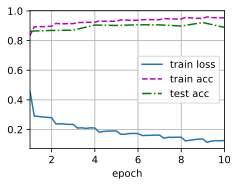

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from d2l import torch as d2l

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())